### Run web-hosted BOPTEST simulation 

For running BOPTEST without the need of local downloads or installations, this simulation uses the BOPTEST  web-hosted environment (BOPTEST-Service). This publicly accessible service allows for the deployment of the test cases in the cloud, enabling interactions via the BOPTEST API. This notebook follows the steps outlined in [this](https://github.com/ibpsa/project1-boptest/blob/master/docs/workshops/BS21Workshop_20210831/Introduction_to_the_BOPTEST_framework.ipynb) BOPTEST tutorial.  

Prior to initiating the simulation, begin by importing the application and configuration files, and selecting the test case and simulation parameters.

### Import Application 
Import application by changing the BOPTest_interface

In [7]:
import sys
sys.path.append("..")

from BOPTest_interface_os_c1_1_zone_temp_adjs_rat import (
    BOPTestControls,
    BOPTestControlFunctions,
    BOPTestInterface
)

from utility_functions import get_hvac_signals

from utility_functions.get_price_threshold import get_price_threshold

class TestCaseInterface(BOPTestInterface):
    def __init__(self, controls, config_path, hvac_signal_function):
        super().__init__(controls, config_path)
        self.hvac_signal_function = hvac_signal_function

    def get_hvac_signals(self, *args):
        return self.hvac_signal_function(*args)
    
    def get_price_threshold(self, *args):
        return get_price_threshold(*args)
    
def create_application(config_path, hvac_signal_function_name) -> BOPTestInterface: 
    '''takes a config file and returns an instantiated TestCaseInterface
    
    Parameters
    ----------
        config_path : str
            the path to a configuration file for instantiating a bestest air shed application 
    Returns
    -------
        application : TestCaseInterface
            returns an instantiated bestest air interface with shedding controls
'''

    functions = BOPTestControlFunctions()
    controls = BOPTestControls(functions)
    hvac_signal_function = getattr(get_hvac_signals, hvac_signal_function_name)
    
    # Instantiate the TestCaseInterface with the controls, config_path, and hvac_signal_function
    application = TestCaseInterface(controls, config_path, hvac_signal_function)
    return application


### Selecting a Test Case and Simulation Parameters
We can select and launch a test case from the repository of [currently available test cases](https://ibpsa.github.io/project1-boptest/testcases/index.html). The simulation paramenters such as the scenario ones (time period and electricity price) can be chosen from the [test cases directory](https://github.com/ibpsa/project1-boptest/tree/master/testcases). Here we can also define the simulation step in seconds. 

In [23]:
# Select test case identifier 
testcase = 'bestest_air'

# Simulation parameters (choosen from https://github.com/ibpsa/project1-boptest/tree/master/testcases)
# scenario
time_period = 'peak_heat_day'
electricity_price ='highly_dynamic'

electricity_price_identifier = 'PriceElectricPowerHighlyDynamic'

# Set simulation step 
step = 900 # 15 min

config_path = 'C:\\Users\\Flavinha\DFLEXLIBS\DFLEXLIBS\examples\boptest\testcase_bestest_air\config_os_c1_1_zone_temp_adjs_rat.yml.yml'
function_name = 'get_' + testcase + '_hvac_signals'
list_power_measurement = ['fcu_reaPHea_y', 'fcu_reaPFan_y', 'fcu_reaPCoo_y']
list_temp_measurement = ['con_oveTSetHea_u', 'con_oveTSetCoo_u', 'zon_reaTRooAir_y']
list_all_measurement = ['fcu_reaPHea_y', 'fcu_reaPFan_y', 'fcu_reaPCoo_y','con_oveTSetHea_u', 'con_oveTSetCoo_u', 'zon_reaTRooAir_y']

### Instantiate Application 
Instantiate the test case interface with shedding controls.

In [24]:
bt_interface = create_application(config_path, function_name)

Error reading configuration file
[Errno 2] No such file or directory: 'examples/boptest/testcase_bestest_air/config_os_c1_1_zone_temp_adjs_rat.yml'


UnboundLocalError: cannot access local variable 'config' where it is not associated with a value

In [49]:
import os

# Step 2: Print current working directory to verify it's correct
print("Current working directory:", os.getcwd())

# Step 3: Construct relative path
relative_config_path = 'examples/boptest/testcase_bestest_air/config_os_c1_1_zone_temp_adjs_rat.yml'

# Step 4: Normalize the path
config_path = os.path.normpath(relative_config_path)

# Step 5: Verify path existence
print("Constructed path:", config_path)
print("Path exists:", os.path.exists(config_path))


Current working directory: c:\Users\Flavinha\DFLEXLIBS\DFLEXLIBS\examples\boptest
Constructed path: examples\boptest\testcase_bestest_air\config_os_c1_1_zone_temp_adjs_rat.yml
Path exists: False


### Launch the Selected Test Case
First, import the Python `requests` library so that we can make HTTP requests to the BOPTEST API at the address indicated by the `url`. Then, use the `POST /testcases/<test_case_name>/select` BOPTEST API endpoint to launch the test case and receive a corresponding `testid`. While the url is the common gateway for everyone to access the BOPTEST web-service, the `testid` is a unique identifier for you to address the test case that you have selected and launched.

In [35]:
import requests
url = "https://api.boptest.net"
testid = \
    requests.post('{0}/testcases/{1}/select'.format(url,testcase)).json()['testid']


Once we have successfully obtained the `testid`, it is possible to start interacting with the selected test case using the rest of the BOPTEST API. For example, use the `GET /name` BOPTEST API endpoint, along with the testid, to request the name of the chosen test case.

In [36]:
# Get test case name
name = requests.get('{0}/name/{1}'.format(url, testid)).json()['payload']
print(name)

{'name': 'bestest_air'}


### Getting Control Input and Measurement Points
While control input and measurement points are described in the [documentation](https://ibpsa.github.io/project1-boptest/testcases/), they are also available to retreive from the BOPTEST API. This is especially useful to store for later when requesting data for a specific point.

Retrieve the control input and measurement outputs using the `GET /inputs` and `GET /measurements` BOPTEST API endpoints.

In [37]:
# Get inputs available
inputs = requests.get('{0}/inputs/{1}'.format(url, testid)).json()['payload']
print('TEST CASE INPUTS ---------------------------------------------')
print(inputs.keys())
# Get measurements available
measurements = requests.get('{0}/measurements/{1}'.format(url, testid)).json()['payload']
print('TEST CASE MEASUREMENTS ---------------------------------------')
print(measurements.keys())

TEST CASE INPUTS ---------------------------------------------
dict_keys(['con_oveTSetCoo_activate', 'con_oveTSetCoo_u', 'con_oveTSetHea_activate', 'con_oveTSetHea_u', 'fcu_oveFan_activate', 'fcu_oveFan_u', 'fcu_oveTSup_activate', 'fcu_oveTSup_u'])
TEST CASE MEASUREMENTS ---------------------------------------
dict_keys(['fcu_reaFloSup_y', 'fcu_reaPCoo_y', 'fcu_reaPFan_y', 'fcu_reaPHea_y', 'zon_reaCO2RooAir_y', 'zon_reaPLig_y', 'zon_reaPPlu_y', 'zon_reaTRooAir_y', 'zon_weaSta_reaWeaCeiHei_y', 'zon_weaSta_reaWeaCloTim_y', 'zon_weaSta_reaWeaHDifHor_y', 'zon_weaSta_reaWeaHDirNor_y', 'zon_weaSta_reaWeaHGloHor_y', 'zon_weaSta_reaWeaHHorIR_y', 'zon_weaSta_reaWeaLat_y', 'zon_weaSta_reaWeaLon_y', 'zon_weaSta_reaWeaNOpa_y', 'zon_weaSta_reaWeaNTot_y', 'zon_weaSta_reaWeaPAtm_y', 'zon_weaSta_reaWeaRelHum_y', 'zon_weaSta_reaWeaSolAlt_y', 'zon_weaSta_reaWeaSolDec_y', 'zon_weaSta_reaWeaSolHouAng_y', 'zon_weaSta_reaWeaSolTim_y', 'zon_weaSta_reaWeaSolZen_y', 'zon_weaSta_reaWeaTBlaSky_y', 'zon_weaSta_re

### Initializing a test scenario
Select a testing scenario using the `PUT /scenario` BOPTEST API endpoint to allow to test the  controller for a pre-defined period and with predefined conditions. It uses the parameters time_period and electricity_price to set a specific scenario as defined for each test case within their respective [documentation](https://github.com/ibpsa/project1-boptest/tree/master/testcases). 

In [38]:
scenario_return = requests.put('{0}/scenario/{1}'.format(url, testid),
    data={'time_period':time_period,
    'electricity_price':electricity_price}).json()['payload']

Setting the scenario API call can return the `time_period` as an argument with current time measurements of the simulation intialized to the scenario time period.
The variable `start_time_days` refers to the start time of the test period.

In [39]:
y = scenario_return['time_period']
start_time_days = y['time']/24/3600

###  Get Forecast Data for Plotting  BOPTEST comfort range

Use the `PUT /forecast` BOPTEST API endpoint with parameters point names referring to the list of forecast data needed, as well as horizon and interval in seconds to set a forecast horizon and data interval. This same endpoint is used to retrieve the forecast data, which will start from the current simulation time.

In [40]:
import pandas as pd
df_f_single_day = pd.DataFrame()
forecast_points = requests.get('{0}/forecast_points/{1}'.format(url, testid)).json()['payload']
list_forecast = list(forecast_points.keys())

# Get the forecast data for the specified point names and time horizon
f = requests.put('{0}/forecast/{1}'.format(url, testid), 
             data={'point_names': list_forecast, 'horizon':24*3600, 'interval':1*3600}).json()['payload']
# Create a dataframe from the forecast data
df_f_single_day = pd.DataFrame.from_dict(f)
    
# Set the index of the dataframe to the time field
df_f_single_day.set_index('time', inplace=True)
    
# Print the dataframe
print(df_f_single_day)

         PriceElectricPowerConstant  PriceGasPower    pAtm       lon  \
time                                                                   
1209600                     0.05461       0.002878  101325 -1.830152   
1213200                     0.05461       0.002878  101325 -1.830152   
1216800                     0.05461       0.002878  101325 -1.830152   
1220400                     0.05461       0.002878  101325 -1.830152   
1224000                     0.05461       0.002878  101325 -1.830152   
1227600                     0.05461       0.002878  101325 -1.830152   
1231200                     0.05461       0.002878  101325 -1.830152   
1234800                     0.05461       0.002878  101325 -1.830152   
1238400                     0.05461       0.002878  101325 -1.830152   
1242000                     0.05461       0.002878  101325 -1.830152   
1245600                     0.05461       0.002878  101325 -1.830152   
1249200                     0.05461       0.002878  101325 -1.83

### Simulating the Baseline Control for Benchmarking
Before testing a new controller, we need to simulate the baseline for a defined scenario and evaluate its performance. The baseline can be quickly simulated by setting a long control step and without overwritting any control signal when advancing the simulation. Here, we even set the control step to one year knowing that the simulation is forced to stop at the end of the scenario time period.

In [41]:
# Set the control step to one year 
requests.put('{0}/step/{1}'.format(url, testid), data={'step':365*24*3600})

# Advance the simulation with no control overwrite
requests.post('{0}/advance/{1}'.format(url, testid), data={}).json()

{'status': 200,
 'message': 'Advanced simulation successfully from 1209600.0s to 2419200.0s.',
 'payload': {'time': 2419200,
  'fcu_reaFloSup_y': -5.780681656157367e-203,
  'fcu_reaPCoo_y': 2.4634404113299475e-200,
  'fcu_reaPFan_y': 0,
  'fcu_reaPHea_y': 0,
  'zon_reaCO2RooAir_y': 426.1397348726117,
  'zon_reaPLig_y': 56.64000000000001,
  'zon_reaPPlu_y': 25.92,
  'zon_reaTRooAir_y': 294.1698042893328,
  'zon_weaSta_reaWeaCeiHei_y': 600,
  'zon_weaSta_reaWeaCloTim_y': 2419200,
  'zon_weaSta_reaWeaHDifHor_y': 0,
  'zon_weaSta_reaWeaHDirNor_y': 0,
  'zon_weaSta_reaWeaHGloHor_y': 0,
  'zon_weaSta_reaWeaHHorIR_y': 289,
  'zon_weaSta_reaWeaLat_y': 0.6939429105929453,
  'zon_weaSta_reaWeaLon_y': -1.830152253641254,
  'zon_weaSta_reaWeaNOpa_y': 1,
  'zon_weaSta_reaWeaNTot_y': 1,
  'zon_weaSta_reaWeaPAtm_y': 101325,
  'zon_weaSta_reaWeaRelHum_y': 0.91,
  'zon_weaSta_reaWeaSolAlt_y': -1.195259345131094,
  'zon_weaSta_reaWeaSolDec_y': -0.3214146902642493,
  'zon_weaSta_reaWeaSolHouAng_y': 172.7

### Getting Core KPI Values
To obtain the KPI, calculated based on the emulator performance during a simulation (starting from the initialization), use the `GET /kpi` BOPTEST API endpoint.

The core KPIs, those that are calculated for every test case, are defined in BOPTEST to evaluate different aspects of a controller. These are:

- **Thermal discomfort**: reported with units of [Kh/zone], defines the cumulative deviation of zone temperatures from upper and lower comfort limits that are predefined within the test case FMU for each zone, averaged over all zones. Air temperature is used for air-based systems and operative temperature is used for radiant systems.

- **Indoor Air Quality (IAQ) Discomfort**: reported with units of [ppmh/zone], defines the extent that the CO
 concentration levels in zones exceed bounds of the acceptable concentration level, which are predefined within the test case FMU for each zone, averaged over all zones.

- **Energy Use**: reported with units of [kWh/m2], defines the HVAC energy usage.

- **Peak electrical demand**:reported with units of [kW/m2], defines the HVAC peak electrical demand.

- **Peak gas demand**:reported with units of [kW/m2], defines the HVAC peak gas demand.

- **Peak district heating demand**:reported with units of [kW/m2], defines the HVAC peak district heating demand.

- **Cost**: reported with units of [USD/m2] or [EUR/m2], defines the operational cost associated with the HVAC energy usage.

- **Emissions**: reported with units of [kgCO2/m2], defines the CO2 emissions from the HVAC energy usage.

- **Computational time ratio**: defines the average ratio between the controller computation time and the test simulation control step. The controller computation time is measured as the time between two emulator advances.

The warmup period is not taken into account for the calculation of the KPIs.


In [42]:
kpis_bas = requests.get('{0}/kpi/{1}'.format(url, testid)).json()['payload']
kpis_bas

{'tdis_tot': 5.749206702446115,
 'idis_tot': 1222.9881103295345,
 'ener_tot': 3.1790567504061285,
 'cost_tot': 0.05622459741828569,
 'emis_tot': 0.8888363250098191,
 'pele_tot': 0.023048425265457306,
 'pgas_tot': 0.11652264230246608,
 'pdih_tot': None,
 'time_rat': None}

### Export Baseline Results

In [43]:
# Export baseline results
import numpy as np


df_pow = pd.DataFrame()
for point in list_power_measurement:
        args = {'point_names':point,
                'start_time':start_time_days*24*3600, 
                'final_time':np.inf}
        pow = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_pow = pd.concat((df_pow,pd.DataFrame(data=pow[point], 
                            index=pow['time'],columns=[point])), axis=1)
df_pow.index.name = 'time'

# Export DataFrame to CSV file

csv_filepower_path = 'baseline_powerData.csv'
df_pow.to_csv(csv_filepower_path)

csv_fileschedule_path = 'scheduleData.csv'
df_f_single_day.to_csv(csv_fileschedule_path)



df_temp = pd.DataFrame()
for tpoint in list_temp_measurement:
        args = {'point_names':tpoint,
                'start_time':start_time_days*24*3600, 
                'final_time':start_time_days*24*3600 + 24*3600}
        temp = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_temp = pd.concat((df_temp,pd.DataFrame(data=temp[tpoint], 
                            index=temp['time'],columns=[tpoint])), axis=1)
df_temp.index.name = 'time'

# Export DataFrame to CSV file
csv_fileTemp_path = 'baseline_tempData.csv'
df_temp.to_csv(csv_fileTemp_path)


df_all = pd.DataFrame()
for tpoint in list_all_measurement:
        args = {'point_names':tpoint,
                'start_time':start_time_days*24*3600, 
                'final_time':start_time_days*24*3600 + 24*3600}
        all = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_all = pd.concat((df_all,pd.DataFrame(data=all[tpoint], 
                            index=all['time'],columns=[tpoint])), axis=1)
df_all.index.name = 'time'

# Export DataFrame to CSV file
csv_fileTemp_path = 'baseline.csv'
df_all.to_csv(csv_fileTemp_path)


print("Baseline data has been exported to data.csv successfully.")


Baseline data has been exported to data.csv successfully.


### Assessing a New Control Strategy
For assessing a new control strategy, we need to initialize the test case in the same scenario used to obtain the baseline controller KPIs, and here we obtain the control step as defined in the setting simulation parameters part. After that, we instantiate the controller and define a simulation loop using the BOPTEST API. Note that the test case will return an empty dictionary when the testing period has elapsed, such that we can loop over the returned measurements without having to infer when the simulation time should end.

In [45]:
import json

# Initialize scenario
y = requests.put('{0}/scenario/{1}'.format(url, testid), 
                 data={'time_period': time_period,
                       'electricity_price':electricity_price}).json()['payload']['time_period']

# Set control step
requests.put('{0}/step/{1}'.format(url, testid), data={'step':step})

# Get step
s = requests.get('{0}/step/{1}'.format(url, testid)).json()['payload']

# Instantiate controller
con = bt_interface

# Simulation loop
from IPython.display import clear_output
while y:

    # Clear the display output at each step
    clear_output(wait=True)

    # Print the current operative temperature and simulation time
    simulation_time_days = y['time']/3600/24
    print('Simulation time [elapsed days] = {:.2f}'.format((simulation_time_days - \
                                                    start_time_days)))
    print('-------------------------------------------------------------------')

    # Get forecast

    points = requests.get('{0}/forecast_points/{1}'.format(url, testid))

    # Parse the response content into a dictionary
    point_data = json.loads(points.content)['payload']

    # Extract the point names from the dictionary
    point_names = [p for p in point_data.keys()]

    # Use the point names as input for the PUT /forecast endpoint
    f = requests.put('{0}/forecast/{1}'.format(url, testid), 
                    data={'point_names': point_names, 'horizon':24*3600, 'interval':1*3600}).json()['payload'] 
    
    # Compute control signal (measurements, forecast, step)
    u = con.control_agent(y,f,s,start_time_days)

    # Advance simulation with control signal
    y = requests.post('{0}/advance/{1}'.format(url, testid), data=u).json()['payload']    


Simulation time [elapsed days] = 5.11
-------------------------------------------------------------------
price_threshold_value 0.05413
0 1 296.70341624773636
self.cool_signal 1 self.heat_signal 0
TSetHeaZon 288.15
TSetCooZon 303.15
TZon 288.1448362517084
occ_min_threshold 0
price_schedule [0.0444, 0.0444, 0.0444, 0.0444, 0.0444, 0.0444, 0.0444, 0.05413, 0.05413, 0.05413, 0.05413, 0.05413, 0.05413, 0.05413, 0.05413, 0.05413, 0.05413, 0.05413, 0.05413, 0.0444, 0.0444, 0.0444, 0.0444, 0.0444, 0.0444]
occupancy_schedule [0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
current_occ_status 0
current_occ_schedule 0
future_occ_schedule 0
current_price 0.0444
future_price 0.0444
TSetMin_baseline 288.15 TSetMin 288.15
TSetMax_baseline 303.15 TSetMax 303.15
runaway condition {'con_oveTSetCoo_u': 303.15, 'con_oveTSetCoo_u_enable': 1, 'con_oveTSetHea_u': 288.15, 'con_oveTSetHea_u_enable': 1}
{'con_oveTSetCoo_u': 303.15, 'con_oveTSetCoo_activate': 1, 'con_oveTSetHea_u': 28

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

### Export Flexible Results

In [ ]:
# Export DF results
import numpy as np


df_pow = pd.DataFrame()
for point in list_power_measurement:
        args = {'point_names':point,
                'start_time':start_time_days*24*3600, 
                'final_time':np.inf}
        pow = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_pow = pd.concat((df_pow,pd.DataFrame(data=pow[point], 
                            index=pow['time'],columns=[point])), axis=1)
df_pow.index.name = 'time'

# Export DataFrame to CSV file
csv_filepower_path = 'flexible_powerData.csv'
df_pow.to_csv(csv_filepower_path)



df_temp = pd.DataFrame()
for tpoint in list_temp_measurement:
        args = {'point_names':tpoint,
                'start_time':start_time_days*24*3600, 
                'final_time':start_time_days*24*3600 + 24*3600}
        temp = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_temp = pd.concat((df_temp,pd.DataFrame(data=temp[tpoint], 
                            index=temp['time'],columns=[tpoint])), axis=1)
df_temp.index.name = 'time'

# Export DataFrame to CSV file
csv_fileTemp_path = 'flexible_tempData.csv'
df_temp.to_csv(csv_fileTemp_path)

print("Flexible data has been exported to data.csv successfully.")

Flexible data has been exported to data.csv successfully.


Get KPIs from Test Control 


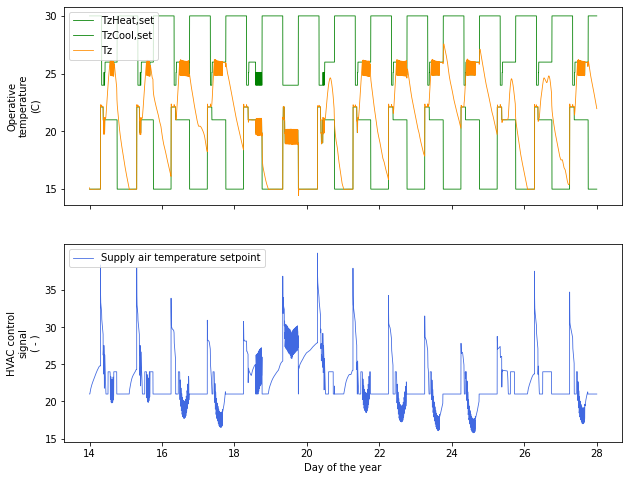

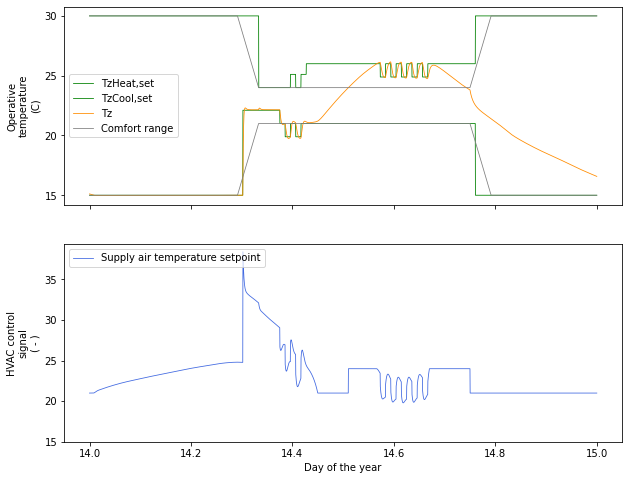

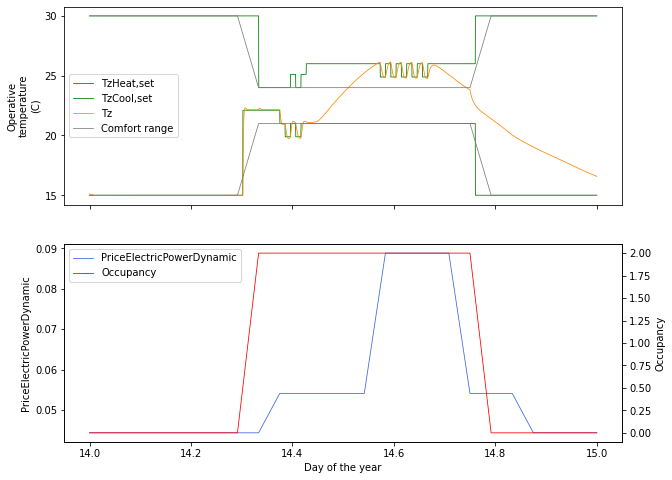

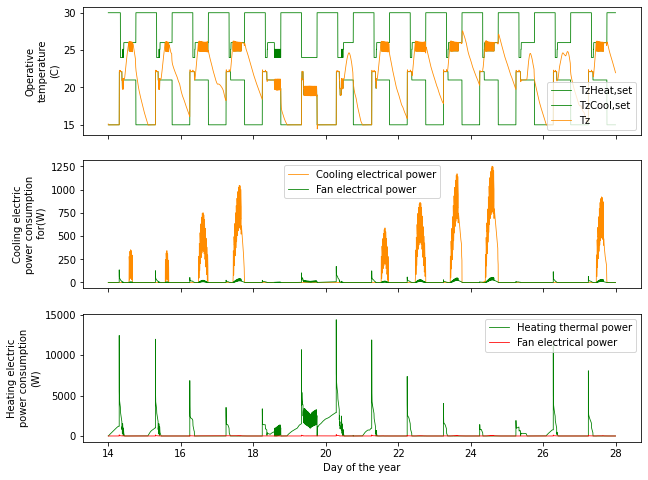

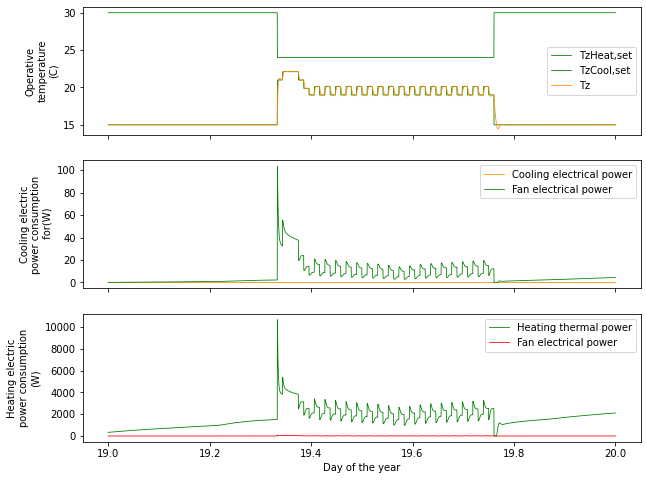

{'tdis_tot': 120.80365552349159, 'idis_tot': 1219.615731632904, 'ener_tot': 3.630405505489658, 'cost_tot': 0.05063815515220187, 'emis_tot': 0.9282341872635126, 'pele_tot': 0.024542602186907646, 'pgas_tot': 0.1616688454800409, 'pdih_tot': None, 'time_rat': 0.003253534093468409}
{'tdis_tot': 5.7492014224358226, 'idis_tot': 1220.535450113058, 'ener_tot': 3.179164909007897, 'cost_tot': 0.056223531769885614, 'emis_tot': 0.8888466329423326, 'pele_tot': 0.023047951663535786, 'pgas_tot': 0.11652363965198106, 'pdih_tot': None, 'time_rat': None}


In [ ]:

# Get and print the test control KPIs
kpis_con = requests.get('{0}/kpi/{1}'.format(url, testid)).json()['payload']
print(kpis_con)

# Print the baseline KPIs
print(kpis_bas)

### Stopping the Test 
We can stop the test case instance in order to free up web-service resources for other test cases. 

In [ ]:
# Set to true if want to stop test case
stop = False
if stop:
  requests.put('{0}/stop/{1}'.format(url, testid))
